In [1]:
import re
import json

import requests

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [2]:
def get_game_pbp_data(game_id):
    response = requests.get(f'https://www.espn.com/mlb/playbyplay/_/gameId/{game_id}')
    bs = BeautifulSoup(response.content)

    scripts = bs.select('script')
    json_blobs = [ script for script in scripts if script.text.startswith("window['__espnfitt__']=") ]
    if len(json_blobs) == 0:
        return []

    json_blob = json_blobs[0].text
    obj = json.loads(json_blob[len('window[\'__espnfitt__\']='):-1])
    return obj['page']['content']['gamepackage']['pbp']

pbp = get_game_pbp_data('401423210')
pbp[0]

{'atBatTeam': {'abbrev': 'LAA',
  'logo': 'https://a.espncdn.com/i/teamlogos/mlb/500/laa.png',
  'name': 'Angels'},
 'awayTeamShortName': 'LAA',
 'homeTeamShortName': 'OAK',
 'errors': 0,
 'hits': 1,
 'period': {'number': 1, 'type': 'Top'},
 'runs': '0',
 'dsc': 'K. Waldichuk pitching for OAK',
 'plays': [{'dsc': 'Rengifo flied out to left.',
   'id': '4014232100001990057',
   'isAway': True,
   'isScoringPlay': False,
   'awayScore': 0,
   'homeScore': 0,
   'defaultOpen': True,
   'pitches': [{'count': 1,
     'dsc': 'Ball',
     'id': '4014232100001020005',
     'ptchCoords': {'x': 76, 'y': 153},
     'ptchDsc': 'Four-seam FB',
     'rslt': 'ball',
     'vlcty': 91,
     'evnts': {'onBase': [False, False, False]}},
    {'count': 2,
     'dsc': 'Strike Swinging',
     'id': '4014232100001030037',
     'ptchCoords': {'x': 119, 'y': 206},
     'ptchDsc': 'Changeup',
     'rslt': 'strike',
     'vlcty': 81},
    {'count': 3,
     'dsc': 'Ball',
     'id': '4014232100001040005',
     'pt

In [3]:
def parse_mlb_pbp_data(pbp):
    pitcher_tracker = {}

    observations = []
    for record in pbp:
        period = record['period']
        atBat = record['atBatTeam']['abbrev']
        period.update({ 'atBat': atBat })

        pitcher = re.search(r'(.+?) pitching', record['dsc'] if 'dsc' in record else '')
        if pitcher is not None:
            pitcher_tracker[atBat] = pitcher.group(1)

        observation = {
            'period': period,
            'batters': []
        }

        for play in record['plays']:
            if 'isPitcherChange' in play and play['isPitcherChange']:
                pitcher_tracker[atBat] = re.search(r'(.+?) pitching', play['dsc']).group(1)

            if 'pitches' in play:
                observation['batters'].append({
                    'pitcher': pitcher_tracker[atBat],
                    'dsc': play['dsc'],
                    'pitches': [ 
                        {
                            'dsc': pitch['dsc'],
                            'coords': pitch['ptchCoords'],
                            'pitchType': pitch['ptchDsc'] if 'ptchDsc' in pitch else '',
                            'result': pitch['rslt'],
                            'velocity': pitch['vlcty'] if 'vlcty' in pitch else '',
                            'bases': [ int(i) for i in pitch['evnts']['onBase'] ] if 'evnts' in pitch and 'onBase' in pitch['evnts'] else [0, 0, 0]
                        }
                        for pitch in play['pitches']
                    ],
                })

        observations.append(observation)

    return observations

half_innings = parse_mlb_pbp_data(pbp)
half_innings[0]

{'period': {'number': 1, 'type': 'Top', 'atBat': 'LAA'},
 'batters': [{'pitcher': 'K. Waldichuk',
   'dsc': 'Rengifo flied out to left.',
   'pitches': [{'dsc': 'Ball',
     'coords': {'x': 76, 'y': 153},
     'pitchType': 'Four-seam FB',
     'result': 'ball',
     'velocity': 91,
     'bases': [0, 0, 0]},
    {'dsc': 'Strike Swinging',
     'coords': {'x': 119, 'y': 206},
     'pitchType': 'Changeup',
     'result': 'strike',
     'velocity': 81,
     'bases': [0, 0, 0]},
    {'dsc': 'Ball',
     'coords': {'x': 42, 'y': 158},
     'pitchType': 'Four-seam FB',
     'result': 'ball',
     'velocity': 92,
     'bases': [0, 0, 0]},
    {'dsc': 'Fly Out',
     'coords': {'x': 74, 'y': 177},
     'pitchType': 'Changeup',
     'result': 'play',
     'velocity': 81,
     'bases': [0, 0, 0]}]},
  {'pitcher': 'K. Waldichuk',
   'dsc': 'Trout walked.',
   'pitches': [{'dsc': 'Foul Ball',
     'coords': {'x': 109, 'y': 147},
     'pitchType': 'Four-seam FB',
     'result': 'strike',
     'veloc

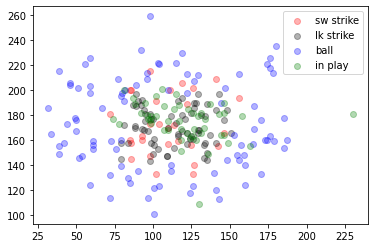

In [4]:
swinging_strikes, looking_strikes, balls, play = [], [], [], []

for item in half_innings:
    for batter in item['batters']:
        for pitch in batter['pitches']:
            result = pitch['result']
            x = pitch['coords']['x']
            y = pitch['coords']['y']
            coords = [x, y]

            if result == 'play':
                play.append(coords)
            if result == 'ball':
                balls.append(coords)
            if result == 'strike':
                if 'Swinging' in pitch['dsc']:
                    swinging_strikes.append(coords)
                else:
                    looking_strikes.append(coords)

plt.scatter(x=[i[0] for i in swinging_strikes], y=[i[1] for i in swinging_strikes], label='sw strike', c='r', alpha=0.3)
plt.scatter(x=[i[0] for i in looking_strikes], y=[i[1] for i in looking_strikes], label='lk strike', c='k', alpha=0.3)
plt.scatter(x=[i[0] for i in balls], y=[i[1] for i in balls], label='ball', c='b', alpha=0.3)
plt.scatter(x=[i[0] for i in play], y=[i[1] for i in play], label='in play', c='g', alpha=0.3)

plt.legend(loc='upper right')
plt.show()